# Import libraries

In [1]:
import uproot
import awkward as ak
import mplhep
%matplotlib inline 
#%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from brokenaxes import brokenaxes
import pandas as pd
from scipy.optimize import curve_fit

# Exercise 3: Measurement of the total production cross sections

Load Data

In [2]:
meanenergy = np.array([88.47939, 89.46793, 90.22266, 91.22430, 91.96648, 92.96465, 93.71712])
lumi = np.array([463.9790, 667.5236, 486.7641, 2246.568, 535.9080, 450.6000, 709.6980])
stat = np.array([2.902361, 3.521166, 3.033955, 6.603405, 3.265110, 3.027953, 3.819882])
sys = np.array([3.104100, 4.471900, 3.261500, 15.04780, 3.585300, 3.020000, 4.762000])
all = np.array([4.249604, 5.691792, 4.454466, 16.43293, 4.849260, 4.276552, 6.104764])

In [89]:
### Open file

file_Opal = uproot.open('daten_4.root')
ttree_name_Opal = 'myTTree'

### Print list of 'branches' of the TTree (i.e. list of variable names)
print('Opal',file_Opal[ttree_name_Opal].keys())

## Load branches
branches_Opal = file_Opal[ttree_name_Opal].arrays()

var_Pcharged = 'Pcharged'
pchar_Opal = ak.to_numpy(branches_Opal[var_Pcharged])

var_Ncharged = 'Ncharged'
nchar_Opal = ak.to_numpy(branches_Opal[var_Ncharged])

var_E_ecal = 'E_ecal'
E_ecal_Opal = ak.to_numpy(branches_Opal[var_E_ecal])

var_E_hcal = 'E_hcal'
E_hcal_Opal = ak.to_numpy(branches_Opal[var_E_hcal])

var_cos_thet = 'cos_thet'
cos_thet_Opal = ak.to_numpy(branches_Opal[var_cos_thet])

var_E_lep = 'E_lep'
E_lep_Opal = ak.to_numpy(branches_Opal[var_E_lep]) 

print(f"Opal {E_lep_Opal} min: {E_lep_Opal.min()}, max: {E_lep_Opal.max()}")

data_Opal = pd.DataFrame({'COM_energy':np.zeros(len(nchar_Opal)), 'ID': np.chararray(len(nchar_Opal)),'Ncharged': nchar_Opal, 'Pcharged': pchar_Opal, 'E_ecal': E_ecal_Opal, 'E_hcal': E_hcal_Opal, 'E_lep':E_lep_Opal, 'cos_thet': cos_thet_Opal})

Opal ['run', 'event', 'Ncharged', 'Pcharged', 'E_ecal', 'E_hcal', 'E_lep', 'cos_thru', 'cos_thet']
Opal [45.627 45.627 45.627 ... 44.732 44.732 44.732] min: 44.23500061035156, max: 46.86199951171875


### separate the 7 different energies

In [34]:
def sevenEnergies(E_lep):
    Energies = np.array(len(E_lep))
    for i in range(len(E_lep)):
        if E_lep[i]<(meanenergy[0]+meanenergy[1])/2:
    elif
        

9441

(array([4.3320e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7200e+02, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 5.9790e+03, 3.5960e+03, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 9.2240e+03, 2.2830e+03, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

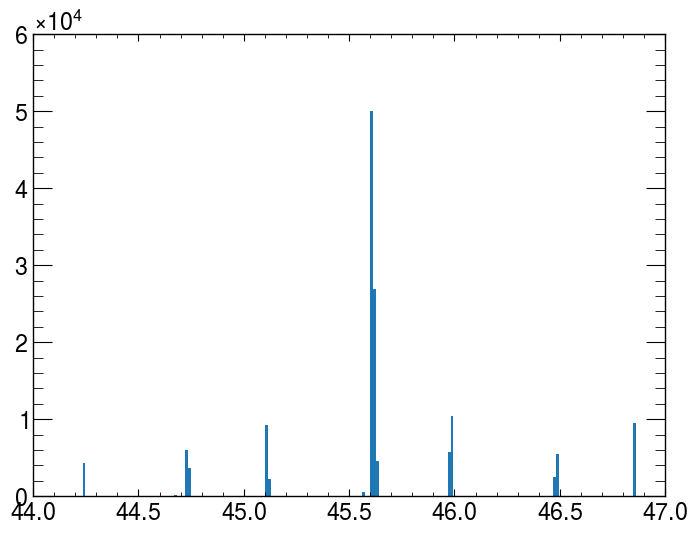

In [97]:
plt.hist(data_Opal.loc[ : , 'E_lep'],bins = 200)
#plt.ylim(10)

In [44]:
data_Opal.loc[ : , 'E_lep'].unique()


array([45.627   , 45.6275  , 45.6265  , 45.61    , 45.6135  , 45.563324,
       45.9865  , 45.9845  , 45.613   , 44.7405  , 44.674732, 45.615   ,
       46.4865  , 45.6155  , 44.2435  , 46.862   , 45.6185  , 45.1175  ,
       44.7425  , 45.6125  , 46.861   , 44.243   , 45.5995  , 45.602   ,
       44.7315  , 44.733   , 45.6065  , 46.48    , 45.6095  , 46.855   ,
       45.609   , 45.1115  , 45.985   , 46.857   , 44.235   , 45.6075  ,
       46.4815  , 44.731   , 45.606   , 45.9805  , 45.107   , 45.109   ,
       44.732   ], dtype=float32)

In [91]:
len(data_Opal.loc[data_Opal['E_lep'] == 44.732]['E_ecal'])

2943

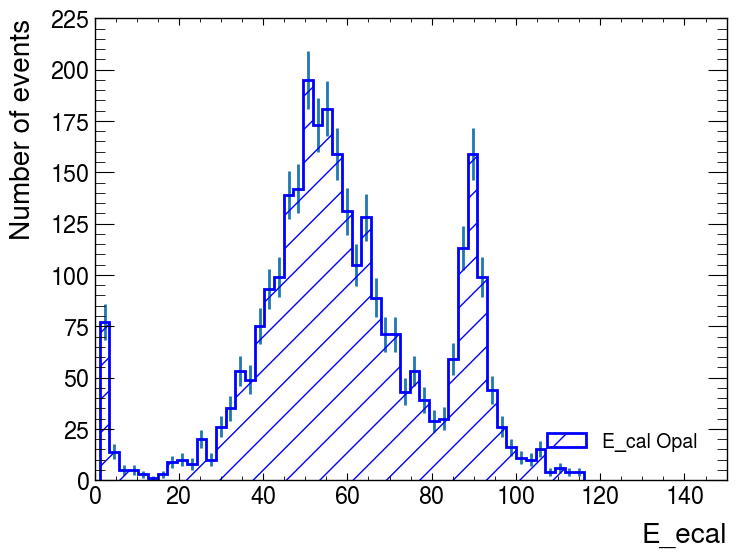

In [90]:
plt.style.use(mplhep.style.ATLAS) # You can load ATLAS/CMS/ALICE plot style 
ratio = [1,4] # ratio of the two subplots

#Opal

bin_content_Opal, bin_edges_Opal, _ = plt.hist(data_Opal.loc[data_Opal['E_lep'] == 44.732]['E_ecal'],bins=50, histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='E_cal Opal')
mid_Opal = 0.5*(bin_edges_Opal[1:] + bin_edges_Opal[:-1]) #Calculate midpoint of the bars

error_sizes = np.sqrt(bin_content_Opal)

plt.errorbar(mid_Opal, bin_content_Opal, yerr=error_sizes, fmt='none')


#plt.ylim(0, 0.7*10**4)  # most of the data



### Show the plot on screen
plt.xlim(0,150)
plt.legend(loc = 4)
plt.xlabel('E_ecal')
plt.ylabel('Number of events')
plt.show()

First determine the number of events in the handronic channel *and* in the three leptonic channels


In [19]:
def classify_event_in_4CH(Ncharged, Pcharged, E_ecal, E_hcal):
    if len(Ncharged)==len(Pcharged)==len(E_ecal)==len(E_hcal):
        PI = np.chararray((len(Ncharged),1), itemsize=2)[:]
        PI[:] = 'NC'      # create start PI array with all events unclassified
        NC = 0      
        ee = 0      
        qq = 0
        mm = 0
        tt = 0                 
        for i in range(len(Ncharged)):
            #print(Ncharged[i])
            if Ncharged[i] >= 7:
                PI[i] = "qq"
                qq += 1
            elif E_ecal[i] >= 60:
                PI[i] = "ee"
                ee += 1
            elif (70<=Pcharged[i] <= 110) & (E_ecal[i] < 20):
                PI[i] = "mm"
                mm += 1
            elif (Pcharged[i] < 10) & (E_ecal[i] < 10):
                PI[i] = "mm"
                mm += 1
            elif (E_ecal[i] < 100) & (1 < Pcharged[i] < 75):
                PI[i] = "tt"
                tt += 1
            else:
                PI[i] = "NC"
                NC += 1

        #print(PI)
        print('ee, mm, tt, qq, NC,len(Ncharged)')
        print(ee, mm, tt, qq, NC,len(Ncharged))
        print()
    else:
        print('Unequaly long input arrays')
    return [[ee, mm, tt, qq, NC, len(Ncharged)], PI]

In [20]:
classify_Opal = classify_event_in_4CH(nchar_Opal, pchar_Opal, E_ecal_Opal, E_hcal_Opal)
data_Opal.loc[:, ['ID']] = classify_Opal[1]

ee, mm, tt, qq, NC,len(Ncharged)
19643 4889 4740 111134 738 141144

